# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import gdown

The next cells contain instructions for downloading data.
**Please, make your own copy.**

In [ ]:
#data
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
#dates
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE

Downloading...
From: https://drive.google.com/uc?id=1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
To: /kaggle/working/x_test_night.npy
100%|███████████████████████████████████████| 58.7M/58.7M [00:00<00:00, 137MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
From (redirected): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY&confirm=t&uuid=8ab6d98b-9693-4caa-acbc-cfd791fa477a
To: /kaggle/working/x_train_night.npy
100%|█████████████████████████████████████████| 382M/382M [00:03<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
To: /kaggle/working/x_val_night.npy
100%|███████████████████████████████████████| 71.4M/71.4M [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
To: /kaggle/working/dates_test_night.npy
100%|██████████████████████████████████████| 3.71k/3.71k [00:00<00:00, 16.5MB/s]
Downloading...
From: https://driv

In [ ]:
#land-sea mask
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK

Downloading...
From: https://drive.google.com/uc?id=1F0GGmrrGtSHizdf0COyHErNqMf9FazCK
To: /kaggle/working/land_sea_mask.npy
100%|██████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 40.6MB/s]


In [ ]:
#a statistical baseline
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ

Downloading...
From: https://drive.google.com/uc?id=1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ
To: /kaggle/working/stat_baseline.npy
100%|███████████████████████████████████████| 48.0M/48.0M [00:00<00:00, 150MB/s]


Le us inspect and visualize data.

In [ ]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

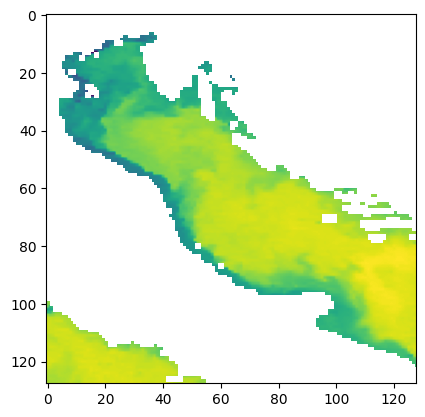

In [ ]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [ ]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


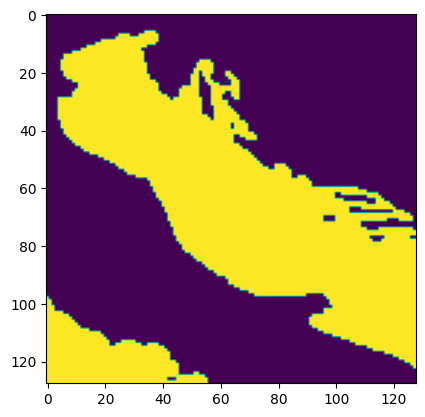

In [ ]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [ ]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


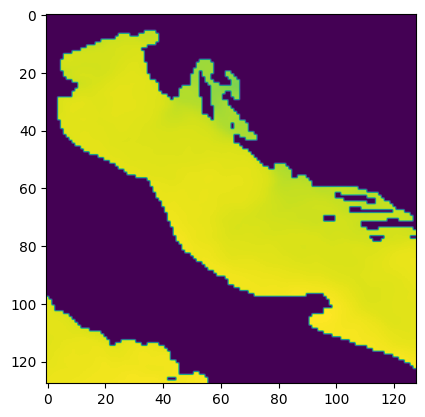

In [ ]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [ ]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [ ]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [ ]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [ ]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [ ]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 25.489999832371893
image 0; 0.0, 25.489999832371893
image 1; 0.0, 25.229999294608376
image 2; 0.0, 24.99778312031531


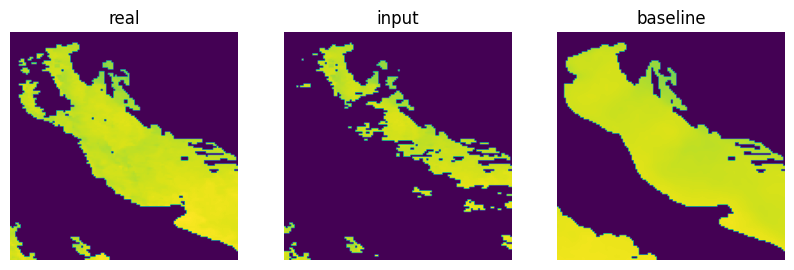

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


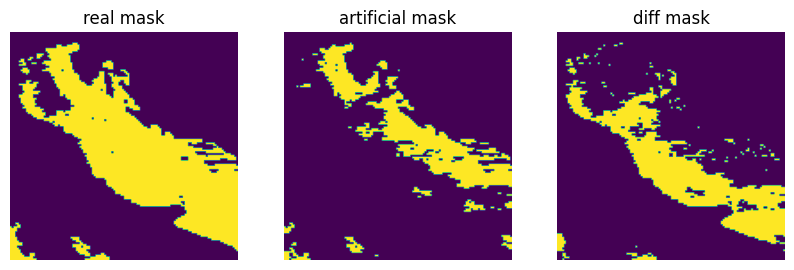

In [ ]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6302487582420833
RMSE std : 0.18885732126463156


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


# Project Summary
For this project, I compared a CNN and U-Net, with U-Net outperforming CNN (0.462 RMSE vs. 0.6). U-Net’s architecture, with its skip connections, was better suited for the pixel-level reconstruction needed. I used the full dataset without additional preprocessing and followed the guideline to keep the test generator unmodified. Although GANs were considered, their complexity was unnecessary. Ultimately, U-Net with Weighted MSE proved the best approach, and all experiments were conducted using TensorFlow.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size=3, padding='same', activation='relu'):
    # Shortcut path
    shortcut = x

    # Residual block path
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)

    # If the shortcut path and residual path dimensions do not match, adjust them
    if tf.keras.backend.int_shape(x) != tf.keras.backend.int_shape(shortcut):
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    # Add shortcut to residual path
    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)
    return x

def build_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder with residual blocks
    c1 = residual_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = residual_block(p3, 256)

    # Decoder with skip connections
    u1 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(b)
    u1 = layers.Concatenate()([u1, c3])
    u1 = residual_block(u1, 128)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(u1)
    u2 = layers.Concatenate()([u2, c2])
    u2 = residual_block(u2, 64)

    u3 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(u2)
    u3 = layers.Concatenate()([u3, c1])
    u3 = residual_block(u3, 32)

    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='linear')(u3)

    model = models.Model(inputs, outputs)
    return model

# Custom loss function (weighted MSE)
def custom_loss(y_true, y_pred):
    mask = y_true[..., 2]  # Assuming the third channel is the mask
    diff = tf.square(y_pred[..., 0] - y_true[..., 0])
    weighted_diff = diff * mask
    return tf.reduce_mean(weighted_diff)

# Create and compile the model
input_shape = (128, 128, 4)  # Image size and number of channels
model = build_unet_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss)

model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_220 (Conv2D) │ (None, 128, 128,  │      1,184 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_221 (Conv2D) │ (None, 128, 128,  │      9,248 │ conv2d_220[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_222 (Conv2D) │ (None, 128, 128,  │        160 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_70 (Add)        │ (None, 128, 128,  │          0 │ conv2d_221[0][0], │
│                     │ 32)               │            │ conv2d_222[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_105      │ (None, 128, 128,  │          0 │ add_70[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 64, 64,    │          0 │ activation_105[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_223 (Conv2D) │ (None, 64, 64,    │     18,496 │ max_pooling2d_30… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_224 (Conv2D) │ (None, 64, 64,    │     36,928 │ conv2d_223[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_225 (Conv2D) │ (None, 64, 64,    │      2,112 │ max_pooling2d_30… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_71 (Add)        │ (None, 64, 64,    │          0 │ conv2d_224[0][0], │
│                     │ 64)               │            │ conv2d_225[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_106      │ (None, 64, 64,    │          0 │ add_71[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 32, 32,    │          0 │ activation_106[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_226 (Conv2D) │ (None, 32, 32,    │     73,856 │ max_pooling2d_31… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_227 (Conv2D) │ (None, 32, 32,    │    147,584 │ conv2d_226[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_228 (Conv2D) │ (None, 32, 32,    │      8,320 │ max_pooling2d_31… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 32, 32,    │          0 │ conv2d_227[0][0]

 Total params: 2,227,843 (8.50 MB)

 Trainable params: 2,227,843 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history = model.fit(train_gen,
                         steps_per_epoch=250,  # Adjusted based on dataset size
                         epochs=80,
                         validation_data=val_gen,
                         validation_steps=100,  # Adjusted based on dataset size
                         callbacks=[lr_scheduler])

Epoch 1/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - loss: 0.0111 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - loss: 0.0042 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 3/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - loss: 0.0041 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - loss: 0.0040 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - loss: 0.0039 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 6/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.0037 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 7/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.0034 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 8/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.0028 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.0028 - val_loss: 0.0024 - learning_rate:

In [ ]:
# Evaluate the model
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    batch_x, batch_y = next(test_gen)
    predictions = model.predict(batch_x, verbose=0)[...,0]

    # Denormalize data
    predictions_denorm = predictions * x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0] * x_train_std + x_train_mean

    # Calculate RMSE
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2, axis=(1, 2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)
print(f"RMSE: {np.mean(RMSE)}")
print(f"RMSE std: {np.std(RMSE)}")

RMSE: 0.462236393113169
RMSE std: 0.15337048359071837
